In [138]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

import torch 
import torch.nn as nn 
import torch.optim as optim
torch.manual_seed(42);

from collections import deque
import random

In [358]:
class Q_Model(nn.Module):
    def __init__(self,input_dim, output_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(input_dim,200), nn.Linear(200,200), nn.ReLU(), nn.Linear(200,output_dim))
    def forward(self,x):
        x = self.mlp(x)
        return x
    
class Agent():
    def __init__(self,initial_pos):
        self.position = initial_pos
        if type(initial_pos) != torch.Tensor:
            self.position = torch.tensor(self.position)

    def move(self,action):
        if action == 0:
            self.position[0] -= 1  # Move left
        elif action == 1:
            self.position[0] += 1  # Move right
        elif action == 2:
            self.position[1] -= 1  # Move up
        elif action == 3:
            self.position[1] += 1  # Move down
        

class Env():
    def __init__(self,Agent,goal, old= None):
        self.goal = goal
        self.agent = Agent
        self.done = False
        if old == None:
            self.old_state = self.compute_initial_state()
        else:
            self.old_state = old
        self.state = self.compute_state()

    def compute_initial_state(self,):
        cur_dist = torch.linalg.norm(self.goal.float() - self.agent.position)
        return cur_dist

    def compute_state(self,):
        # return self.agent.position
        # return torch.concatenate((self.agent.position, self.goal)).float()
        cur_dist = torch.linalg.norm(self.goal.float() - self.agent.position)
        if self.old_state.shape != torch.Size([]):
            past_dist = self.old_state[1]
        else:
            past_dist = self.old_state
        return torch.Tensor([past_dist,cur_dist])

    def reward(self,):
        if any([torch.abs(x) >= 10 for x in self.agent.position]):
            self.done = True
            # self.state = -10
            return -10
        else:
            # dist = self.compute_state()
            if torch.all(self.agent.position.float() == self.goal.float()):
                self.done = torch.all(self.agent.position.float() == self.goal.float())
                return 10
            else:
                return 0 #1/(dist + 1)

    def view(self):
        plt.plot(self.agent.position[0],self.agent.position[1],".", color = "blue")
        plt.plot(self.goal[0],self.goal[1],".", color = "red")
        rectangle = patches.Rectangle((-10, -10), 20, 20, linewidth=2, edgecolor='r', facecolor='none')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_patch(rectangle)
        plt.title("Bob Game")
        plt.text(6,11,f"Reward: {self.reward():.3f}")
        plt.text(self.agent.position[0]-0.5,self.agent.position[1]+0.5, "Bob")
        plt.text(self.goal[0] - 0.85 ,self.goal[1] + 0.5, "Alice")
        plt.text(-10,11, f"Bob:{self.agent.position[0].item(),self.agent.position[1].item()}")
        plt.xlim(-14,14)
        plt.ylim(-14,14)

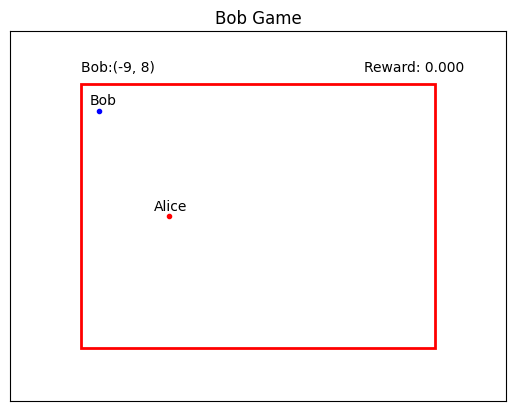

In [299]:
bob = Agent(torch.randint(-10,10,size=(2,)))
state = Env(bob, goal = torch.randint(-9,9,size=(2,)))
state.view()


In [375]:
goal = torch.randint(-9,9,size=(2,))
from matplotlib import rc
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
env = Env(bob,goal)
bob = Agent(torch.randint(-9,9,size=(2,)))

def animate(i):
    global fig,goal
    fig.clear()
    env = Env(bob, goal = goal)
    state = env.state
    q_values = model(state)
    action=  q_values.argmax().item()
    bob.move(action)
    if i%100 ==0 or (any([torch.abs(x) >= 10 for x in env.agent.position])) or torch.all(env.agent.position.float() == env.goal.float()):
        bob.position = torch.tensor([0.,0.])
        goal = torch.randint(-9,9,size=(2,))
        state = Env(bob, goal = goal)
    env.view();
    fig = plt.gcf()

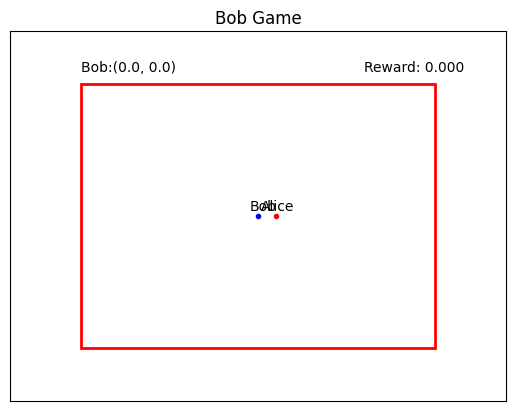

In [376]:
fig, ax = plt.subplots(1,1)
ani = FuncAnimation(fig,animate,frames=300,interval = 50)
ani

In [372]:
model = Q_Model(2,4)

In [362]:
lr = 1e-4
gamma = 0.9
epsilon = 100
num_episodes = 30000
batch_size = 2
max_steps = 100

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
gamma = gamma

replay_buffer = deque(maxlen=10000)


def select_action(state, epsilon,episode_n, max_n):
    if (torch.randint(low=0,high= 200, size=(1,)) < epsilon) and episode_n < max_n:
        return torch.randn(size= (4,)).argmax().item()
    else:
        with torch.no_grad():
            q_values = model(state)
            return q_values.argmax().item()
        

for n,episode in enumerate(range(num_episodes)):
    bob = Agent(torch.randint(-9,9,size=(2,)))
    goal = torch.randint(-9,9,size=(2,))
    env = Env(bob, goal = goal)
    state = env.state
    env.old_state = state
    total_reward = 0
    game_over = env.done
    max_n = int(num_episodes*0.3)

    

    for step in range(max_steps):
        action = select_action(state,epsilon=epsilon,episode_n=n, max_n=max_n)
        # print(f"Reward:{reward}, Action: {action}, Done?: {game_over}, Bob:{bob.position}, Alice:{env.goal}")
        bob.move(action=action)
        env = Env(bob, goal = goal, old = state)
        # print(env.old_state, env.state)
        env.old_state = state
        next_state = env.state
        reward = env.reward()
        game_over = env.done

        replay_buffer.append((state, action, reward, next_state, game_over))

        # Update the current state
        state = next_state

        # Update the total reward
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size)

            # Extract the components of the minibatch
            states, actions, rewards, next_states, dones = zip(*minibatch)

            # Convert the components to PyTorch tensors
            states = torch.vstack(states)
            actions = torch.LongTensor(actions)
            rewards = torch.Tensor(rewards)
            next_states = torch.vstack(next_states)
            dones = torch.Tensor(dones)

            # Compute the Q-values for the current state and next state
            q_values = model(states)
            next_q_values = model(next_states)

            # Compute the target Q-values using the Bellman equation
            target_q_values = rewards + gamma * next_q_values.max(dim=1)[0] * (1 - dones)

            # Compute the predicted Q-values for the current state and selected actions
            predicted_q_values = q_values.gather(dim=-1, index=actions.unsqueeze(-1)).squeeze(-1)
            # Compute the loss
            loss = criterion(predicted_q_values, target_q_values)

            # Perform a gradient descent step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        if game_over:
            print("Morreu")
            break
        
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Loss:: {loss}")


        

Morreu
Episode 1/30000, Total Reward: -10, Loss:: 0.0029676395934075117
Morreu
Episode 2/30000, Total Reward: -10, Loss:: 0.0006295119528658688
Episode 3/30000, Total Reward: 0, Loss:: 0.2944629192352295
Morreu
Episode 4/30000, Total Reward: 10, Loss:: 0.23890180885791779
Morreu
Episode 5/30000, Total Reward: -10, Loss:: 0.01674378290772438
Morreu
Episode 6/30000, Total Reward: -10, Loss:: 0.9955333471298218
Morreu
Episode 7/30000, Total Reward: -10, Loss:: 0.08501335978507996
Morreu
Episode 8/30000, Total Reward: -10, Loss:: 0.9642878174781799
Episode 9/30000, Total Reward: 0, Loss:: 0.6490247249603271
Morreu
Episode 10/30000, Total Reward: -10, Loss:: 0.2511023283004761
Morreu
Episode 11/30000, Total Reward: -10, Loss:: 0.3058793842792511
Morreu
Episode 12/30000, Total Reward: -10, Loss:: 0.23258790373802185
Morreu
Episode 13/30000, Total Reward: -10, Loss:: 0.4601038694381714
Morreu
Episode 14/30000, Total Reward: -10, Loss:: 0.3728317320346832
Morreu
Episode 15/30000, Total Reward:

In [281]:
replay_buffer

deque([(tensor([ 0., -2.,  5.,  2.]),
        1,
        0,
        tensor([ 1., -2.,  5.,  2.]),
        False),
       (tensor([ 1., -2.,  5.,  2.]),
        3,
        0,
        tensor([ 1., -1.,  5.,  2.]),
        False),
       (tensor([ 1., -1.,  5.,  2.]), 3, 0, tensor([1., 0., 5., 2.]), False),
       (tensor([1., 0., 5., 2.]), 1, 0, tensor([2., 0., 5., 2.]), False),
       (tensor([2., 0., 5., 2.]), 3, 0, tensor([2., 1., 5., 2.]), False),
       (tensor([2., 1., 5., 2.]), 1, 0, tensor([3., 1., 5., 2.]), False),
       (tensor([3., 1., 5., 2.]), 1, 0, tensor([4., 1., 5., 2.]), False),
       (tensor([4., 1., 5., 2.]), 3, 0, tensor([4., 2., 5., 2.]), False),
       (tensor([4., 2., 5., 2.]),
        1,
        10,
        tensor([5., 2., 5., 2.]),
        tensor(True)),
       (tensor([ 5., -4., -8.,  3.]),
        0,
        0,
        tensor([ 4., -4., -8.,  3.]),
        False),
       (tensor([ 4., -4., -8.,  3.]),
        0,
        0,
        tensor([ 3., -4., -8.,  3.])

In [258]:
torch.vstack((torch.tensor([1,2]),torch.tensor([1,2])))

tensor([[1, 2],
        [1, 2]])

In [154]:
replay_buffer

deque([(tensor(14.0357), 1, tensor(0.0667), tensor(14.), False),
       (tensor(14.), 1, tensor(0.0665), tensor(14.0357), False),
       (tensor(14.0357), 1, tensor(0.0660), tensor(14.1421), False),
       (tensor(14.1421), 1, tensor(0.0653), tensor(14.3178), False),
       (tensor(14.3178), 1, tensor(0.0643), tensor(14.5602), False),
       (tensor(14.5602), 1, tensor(0.0630), tensor(14.8661), False),
       (tensor(14.8661), 1, tensor(0.0616), tensor(15.2315), False),
       (tensor(15.2315), 1, tensor(0.0601), tensor(15.6525), False),
       (tensor(15.6525), 1, tensor(0.0584), tensor(16.1245), False),
       (tensor(16.1245), 1, tensor(0.0567), tensor(16.6433), False),
       (tensor(16.6433), 0, tensor(0.0584), tensor(16.1245), False),
       (tensor(16.1245), 0, tensor(0.0601), tensor(15.6525), False),
       (tensor(15.6525), 3, tensor(0.0634), tensor(14.7648), False),
       (tensor(14.7648), 3, tensor(0.0671), tensor(13.8924), False),
       (tensor(13.8924), 3, tensor(0.0712)